In [1]:
import torch
import seqgen.seq_gen as g
import random
import matplotlib.pyplot as plt
import seaborn as sns

torch.autograd.set_detect_anomaly(True)

%load_ext autoreload
%autoreload 2

In [2]:
if torch.cuda.device_count():
    device="cuda"
else:
    device="cpu"
print("Device", device)

Device cuda


In [3]:
lr = 1e-2
num_layers=1
embedding_dim = 64
hidden_size=64
batch_size=32
max_length=20
bidirectional=True

In [4]:
features, target_seqs = g.generate_synthetic_training_data(batch_size, max_length=max_length, device=device, continue_prob=0.997, swap_times=0)
input_seqs = torch.tensor(features[:, :, 0]).to(torch.int64)
coordinates = torch.tensor(features[:, :, 1:])

C:\Users\tilof\AppData\Local\Temp\ipykernel_14556\3989188473.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seqs = torch.tensor(features[:, :, 0]).to(torch.int64)
C:\Users\tilof\AppData\Local\Temp\ipykernel_14556\3989188473.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coordinates = torch.tensor(features[:, :, 1:])


In [5]:
features.shape, input_seqs.shape, coordinates.shape, target_seqs.shape

(torch.Size([32, 20, 5]),
 torch.Size([32, 20]),
 torch.Size([32, 20, 4]),
 torch.Size([32, 20]))

# The Encoder

In [6]:
from seqgen.model import seq2seq_lstm
from seqgen.vocabulary import *

In [9]:
load_from_checkpoint = False
checkpoint_file = "model_len25_biy_layers3.pt"

vocab_in = Vocabulary(vocab_filename="seqgen/vocab_in.txt")
vocab_out = Vocabulary(vocab_filename="seqgen/vocab_out.txt")

encoder = seq2seq_lstm.EncoderRNN(vocab_size=len(vocab_in), embedding_dim=embedding_dim, num_layers=num_layers, max_length=max_length, hidden_size=hidden_size, bidirectional=bidirectional, pos_encoding=False).to(features.device)
decoder = seq2seq_lstm.DecoderLSTMAttention(embedding_dim=embedding_dim, num_layers=num_layers, max_length=max_length, hidden_size=hidden_size, vocab_size=len(vocab_out), bidirectional=bidirectional, pos_encoding=False).to(features.device)

# Initialize optimizer for encoder and decoder
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
#positions = seq2seq_lstm.get_position_encoding(max_length, embedding_dim, device=device)
positions = seq2seq_lstm.get_coordinate_encoding(coordinates, d=embedding_dim, device=device)

# Loss function
criterion = torch.nn.NLLLoss()

# Load model weights from checkpoint
if load_from_checkpoint:
    checkpoint = torch.load(checkpoint_file)
    encoder.load_state_dict(checkpoint['encoder_model_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_model_state_dict'])
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    num_layers = checkpoint['num_layers']
    embedding_dim = checkpoint['embedding_dim']
    hidden_size = checkpoint['hidden_size']
    bidirectional = checkpoint['bidirectional']

In [10]:
# Initialize the encoder hidden state and cell state with zeros
hn = encoder.initHidden(input_seqs.shape[0], device=features.device)
cn = encoder.initHidden(input_seqs.shape[0], device=features.device)

_hidden_size = hidden_size * 2 if bidirectional else hidden_size
encoder_hidden_states = torch.zeros((batch_size, max_length, _hidden_size*num_layers)).to(device)
encoder_outputs = torch.zeros((batch_size, max_length, _hidden_size)).to(device)

# Iterate over the sequence words and run every word through the encoder
for i in range(input_seqs.shape[1]):
    # Run the i-th word of the input sequence through the encoder.
    # As a result we will get the prediction (output), the hidden state and the cell state.
    # The hidden state and cell state will be used as inputs in the next round
    print(f"Run word {i+1} of all {input_seqs.shape[0]} sequences through the encoder")
    output, (hn, cn) = encoder(input_seqs[:, i].unsqueeze(dim=1), coordinates[:, i], positions[:, i:i+1], (hn, cn))
    encoder_outputs[:, i:i+1, :] = output
    encoder_hidden_states[:, i, :] = seq2seq_lstm.concat_hidden_states(hn)

Run word 1 of all 32 sequences through the encoder
Run word 2 of all 32 sequences through the encoder
Run word 3 of all 32 sequences through the encoder
Run word 4 of all 32 sequences through the encoder
Run word 5 of all 32 sequences through the encoder
Run word 6 of all 32 sequences through the encoder
Run word 7 of all 32 sequences through the encoder
Run word 8 of all 32 sequences through the encoder
Run word 9 of all 32 sequences through the encoder
Run word 10 of all 32 sequences through the encoder
Run word 11 of all 32 sequences through the encoder
Run word 12 of all 32 sequences through the encoder
Run word 13 of all 32 sequences through the encoder
Run word 14 of all 32 sequences through the encoder
Run word 15 of all 32 sequences through the encoder
Run word 16 of all 32 sequences through the encoder
Run word 17 of all 32 sequences through the encoder
Run word 18 of all 32 sequences through the encoder
Run word 19 of all 32 sequences through the encoder
Run word 20 of all 32

In [11]:
output.shape, hn.shape, cn.shape, encoder_hidden_states.shape, encoder_outputs.shape

(torch.Size([32, 1, 128]),
 torch.Size([2, 32, 64]),
 torch.Size([2, 32, 64]),
 torch.Size([32, 20, 128]),
 torch.Size([32, 20, 128]))

# The Decoder

In [12]:
loss = 0

# Iterate over words of target sequence and run words through the decoder.
# This will produce a prediction for the next word in the sequence
for i in range(0, target_seqs.size(1)):
    print(f"Run word {i+1} through decoder", hn.shape, encoder_hidden_states.shape)
    output, (hn, cn), attention = decoder(
        x=target_seqs[:, i].unsqueeze(dim=1),
        coordinates=coordinates[:, i],
        annotations=encoder_hidden_states,
        position=positions[:, i:i+1],
        hidden=(hn, cn)
    )
    loss += criterion(output.squeeze(), target_seqs[:, i])

print("LOSS", loss.item() / max_length)

Run word 1 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 2 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 3 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 4 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 5 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 6 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])


C:\Users\tilof\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Run word 7 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 8 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 9 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 10 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 11 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 12 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 13 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 14 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 15 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 16 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 17 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 18 through decoder torch.Size([2, 32, 64]) torch.Size([32, 20, 128])
Run word 19 through decoder torch.Size([2, 32, 64]) torch.Size([32,

# Training

In [ ]:
history = []
accuracies = []

for epoch in range(100000):
    # With a certain chance present the model the true predictions
    # instead of its own predictions in the next iteration
    use_teacher_forcing_prob = 0.5
    use_teacher_forcing = random.random() < use_teacher_forcing_prob
    
    # Get a batch of trianing data
    features, target_seqs = g.generate_synthetic_training_data(batch_size, max_length=max_length, continue_prob=0.99, device=device, swap_times=0)
    features = features.to(device)
    target_seqs = target_seqs.to(device)
    input_seqs = torch.tensor(features[:, :, 0]).to(torch.int64)
    coordinates = torch.tensor(features[:, :, 1:])

    # Initialize the encoder hidden state and cell state with zeros
    hn_enc = encoder.initHidden(input_seqs.shape[0], device=features.device)
    cn_enc = encoder.initHidden(input_seqs.shape[0], device=features.device)
    
    # Initialize encoder outputs tensor
    last_n_states = 2 if bidirectional else 1
    _hidden_size = hidden_size * 2 if bidirectional else hidden_size
    encoder_hidden_states = torch.zeros((batch_size, max_length, _hidden_size*num_layers)).to(device)
    encoder_outputs = torch.zeros((batch_size, max_length, _hidden_size)).to(device)
    
    # Set gradients of all model parameters to zero
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Initialize loss
    loss = 0
    
    ####################
    #     ENCODING     #
    ####################

    # Iterate over the sequence words and run every word through the encoder
    for i in range(input_seqs.shape[1]):
        # Run the i-th word of the input sequence through the encoder.
        # As a result we will get the prediction (output), the hidden state (hn) and the cell state (cn).
        # The hidden state and cell state will be used as inputs in the next round
        output, (hn_enc, cn_enc) = encoder(
            input_seqs[:, i].unsqueeze(dim=1),
            coordinates[:, i],
            positions[:, i:i+1],
            (hn_enc, cn_enc)
        )
        # Save encoder outputs and states for current word
        encoder_outputs[:, i:i+1, :] = output
        encoder_hidden_states[:, i, :] = seq2seq_lstm.concat_hidden_states(hn)

    ####################
    #     DECODING     #
    ####################
    
    accuracy = 0.0

    # The first words that we be presented to the model is the '<start>' token
    prediction = target_seqs[:, 0]
    
    # The initial hidden state of the decoder is the final hidden state of the encoder
    hn_dec, cn_dec = hn_enc, cn_enc
    
    # Iterate over words of target sequence and run words through the decoder.
    # This will produce a prediction for the next word in the sequence
    for i in range(1, target_seqs.size(1)):
        # Run word i through decoder and get word i+1 and the new hidden state as outputs
        if use_teacher_forcing:
            output, (hn_dec, cn_dec), attention = decoder(
                x=prediction.unsqueeze(dim=1),
                coordinates=coordinates[:, i-1],
                annotations=encoder_hidden_states,
                position=positions[:, i:i+1],
                hidden=(hn_dec, cn_dec)
            )
        else:
            output, (hn_dec, cn_dec), attention = decoder(
                x=prediction.unsqueeze(dim=1),
                coordinates=coordinates[:, i-1],
                annotations=encoder_hidden_states,
                position=positions[:, i:i+1],
                hidden=(hn_dec, cn_dec)
            )

            # Get the predicted classes of the model
            topv, topi = output.topk(1)
            prediction = topi.squeeze()    
        loss += criterion(output.squeeze(), target_seqs[:, i])
        accuracy += float((prediction == target_seqs[:, i]).sum() / (target_seqs.size(0)*target_seqs.size(1)))
    
    history.append(loss.item())
    accuracies.append(accuracy)
    
    print_every = 100
    if not epoch % print_every:
        _accuracy = sum(accuracies[-print_every:]) / print_every
        print(f"LOSS after epoch {epoch}", loss.item() / (target_seqs.size(1)), "ACCURACY", _accuracy)

    # Compute gradient
    loss.backward()
    accuracy = 0.0

    # Update weights of encoder and decoder
    encoder_optimizer.step()
    decoder_optimizer.step()

C:\Users\tilof\AppData\Local\Temp\ipykernel_14556\1797800676.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seqs = torch.tensor(features[:, :, 0]).to(torch.int64)
C:\Users\tilof\AppData\Local\Temp\ipykernel_14556\1797800676.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coordinates = torch.tensor(features[:, :, 1:])


LOSS after epoch 0 1.3657781600952148 ACCURACY 0.0
LOSS after epoch 100 1.5163612365722656 ACCURACY 0.2063437541620806
LOSS after epoch 200 1.357155704498291 ACCURACY 0.1831875035748817
LOSS after epoch 300 1.4871570587158203 ACCURACY 0.21540625410154463
LOSS after epoch 400 1.468447780609131 ACCURACY 0.19165625381981954
LOSS after epoch 500 1.4287606239318849 ACCURACY 0.2448281293886248
LOSS after epoch 600 1.5602463722229003 ACCURACY 0.22242187896277754
LOSS after epoch 700 1.4016406059265136 ACCURACY 0.21118750390363858
LOSS after epoch 800 1.3715116500854492 ACCURACY 0.22389062916859984
LOSS after epoch 900 1.568272876739502 ACCURACY 0.23265625465661288
LOSS after epoch 1000 1.3579626083374023 ACCURACY 0.19409375369665213
LOSS after epoch 1100 1.5044645309448241 ACCURACY 0.23442187945591286
LOSS after epoch 1200 1.4579524040222167 ACCURACY 0.2175468794023618
LOSS after epoch 1300 1.4644655227661132 ACCURACY 0.19443750351667405
LOSS after epoch 1400 1.4049686431884765 ACCURACY 0.236

#### Save model history

In [ ]:
import pickle
from datetime import datetime

model_data = {
    "history": history,
    "lr": lr,
    "embedding_dim": embedding_dim,
    "hidden_size": hidden_size,
    "batch_size": batch_size,
    "max_length": max_length
}

now = datetime.now() # current date and time
date_time = now.strftime("%Y-%m-%d_%H-%M-%S")

torch.save({
    'epoch': epoch,
    'encoder_model_state_dict': encoder.state_dict(),
    'decoder_model_state_dict': decoder.state_dict(),
    'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
    'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
    'loss': loss,
    "history": history,
    "lr": lr,
    "embedding_dim": embedding_dim,
    "hidden_size": hidden_size,
    "batch_size": batch_size,
    "max_length": max_length,
    "num_layers": num_layers,
    "bidirectional": bidirectional,
}, "model_" + date_time + ".pt")


with open("training_" + date_time + '.pkl', 'wb') as f:
    pickle.dump(model_data, f)

## Make predictions

We run our input sequences through the model and get output seuences. Then we decode the output sequences with the Vocabulary class and get our final latex code.

In [14]:
def predict(input_seqs, coordinates, target_seqs):
    vocab_in = Vocabulary(vocab_filename="seqgen/vocab_in.txt")
    vocab_out = Vocabulary(vocab_filename="seqgen/vocab_out.txt")

    predictions = torch.zeros(target_seqs.shape)
    attention_matrix = torch.zeros((input_seqs.shape[0], input_seqs.shape[1], input_seqs.shape[1]))

    with torch.no_grad():
        # Initialize the encoder hidden state and cell state with zeros
        hn = encoder.initHidden(input_seqs.shape[0], device=features.device)
        cn = encoder.initHidden(input_seqs.shape[0], device=features.device)
        
        _hidden_size = hidden_size * 2 if bidirectional else hidden_size
        last_n_states = 2 if bidirectional else 1
        encoder_hidden_states = torch.zeros((input_seqs.shape[0], max_length, _hidden_size)).to(device)
        encoder_outputs = torch.zeros((input_seqs.shape[0], max_length, _hidden_size)).to(device)

        # Iterate over the sequence words and run every word through the encoder
        for i in range(input_seqs.size(1)):
            output, (hn, cn) = encoder(
                input_seqs[:, i].unsqueeze(dim=1),
                coordinates[:, i],
                positions[:, i:i+1],
                (hn, cn)
            )
            encoder_outputs[:, i:i+1, :] = output
            encoder_hidden_states[:, i:i+1, :] = seq2seq_lstm.concat_hidden_states(hn[-last_n_states:]).unsqueeze(dim=1)

        # Predict tokens of the target sequence by running the hidden state through
        # the decoder
        for i in range(0, target_seqs.size(1)):
            output, (hn, cn), attention = decoder(
                x=target_seqs[:, i].unsqueeze(dim=1),
                coordinates=coordinates[:, i],
                annotations=encoder_hidden_states,
                position=positions[:, i:i+1],
                hidden=(hn, cn)
            )
            # Select the indices of the most likely tokens
            predicted_char = torch.argmax(output, dim=2)
            predictions[:, i] = torch.argmax(output, dim=2).squeeze()
            attention_matrix[:, :, i:i+1] = attention
        
        return predictions, attention_matrix

In [15]:
prediction, attention_matrix = predict(input_seqs[0:2], coordinates[0:2], target_seqs[0:2])
prediction.shape, attention_matrix.shape

(torch.Size([2, 20]), torch.Size([2, 20, 20]))

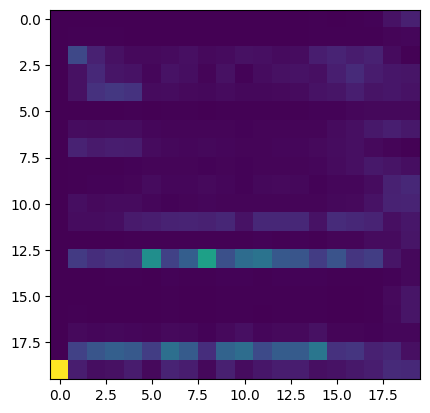

In [16]:
plt.imshow(attention_matrix[0])

In [ ]:
in_swapped = g.random_swap(input_seqs[0], i=2).unsqueeze(dim=0)
coords_swapped = g.random_swap(coordinates[0], i=2).unsqueeze(dim=0)
prediction_swapped = predict(in_swapped, coords_swapped, target_seqs[0:1])

In [ ]:
input_seqs[0:1] == in_swapped

In [ ]:
prediction == prediction_swapped

In [ ]:
# Pick random sequence and its prediction from the model
import random

vocab_in = Vocabulary(vocab_filename="seqgen/vocab_in.txt")
vocab_out = Vocabulary(vocab_filename="seqgen/vocab_out.txt")

predictions, attention_matrix = predict(input_seqs, coordinates, target_seqs)

i = random.randint(0, predictions.size(0))
print("MODEL INPUT", vocab_in.decode_sequence(input_seqs[i].cpu().numpy()))
print("MODEL OUTPUT", vocab_out.decode_sequence(predictions[i].cpu().numpy()))
print("TARGET OUTPUT", vocab_out.decode_sequence(target_seqs[i][1:].cpu().numpy()))

In [ ]:
prediction = vocab_out.decode_sequence(predictions[i].cpu().numpy())
prediction = list(filter(lambda x: x != '<end>', prediction))
prediction = "".join(prediction)
print("MODEL OUTPUT", prediction)

In [ ]:
sns.heatmap(attention_matrix[0])